### Content-Based Filtering: Overview and Motivation

**Content-based filtering** is a recommendation approach that suggests items to a user based on the **similarity between item attributes and the user’s profile**. Each item (e.g., video, product, article) is described by a set of features — such as categories, metadata, or text — and each user is represented by a profile built from the features of the items they liked or interacted with.

---

#### Why Choose Content-Based Filtering?

- **No need for user overlap**: Unlike collaborative filtering, it works well even when users don't share many common interactions.
- **Cold-start friendly for users**: New users can receive recommendations as soon as they interact with a few items.
- **Explainability**: Recommendations are based on content similarity, making it easier to interpret why an item was recommended.
- **Control and customization**: Designers can influence recommendations by choosing or engineering relevant item features (e.g., engagement stats, captions, categories).
- **Independence from other users**: User preferences are modeled individually, which avoids popularity bias and herd effects.

---

#### Limitations (to be addressed in hybrid systems)

- It may lead to **narrow recommendations** (serendipity is limited).
- It doesn't leverage the collective behavior of similar users.
- It can underperform if **content features are not expressive enough**.

---

In summary, content-based filtering is a strong baseline for recommendation, especially when:
- item metadata is rich,
- user preferences are diverse,
- and we want transparent and controllable recommendations.


In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import json
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ndcg_score
from sklearn.feature_extraction.text import TfidfVectorizer

DATA_PATH = 'data_final_project/KuaiRec 2.0/data/'


### Load Data

### Dataset Description

The recommendation system is based on several CSV files that represent user interactions and video metadata:

---

#### `big_matrix.csv`
- Contains historical **user-video interactions**.
- Used for **training** user profiles.
- Includes fields like: `user_id`, `video_id`, `watch_ratio`, `play_duration`, etc.

#### `small_matrix.csv`
- Contains **test interactions**, recorded after the training period.
- Used to **evaluate** recommendation quality.

---

#### `item_daily_features.csv`
- Provides **daily aggregated statistics per video**, such as:
  - `play_cnt`, `like_cnt`, `comment_cnt`, `complete_play_cnt`, etc.
- Used to compute **engagement metrics** and **popularity scores**.

#### `item_categories.csv`
- Contains **categorical tags** per video.
- Field `feat` is a list of semantic categories.
- Used for **one-hot encoding** of video types or genres.

---

#### `kuairec_caption_category.csv`
- Includes **textual metadata** per video:
  - `caption`, `manual_cover_text`, and topic-level categories.
- Used to extract **TF-IDF features** from captions for semantic modeling.


In [2]:

print("Loading datasets...")
		
# Load interaction data
interactions_train = pd.read_csv(os.path.join(DATA_PATH, "big_matrix.csv"))
interactions_test = pd.read_csv(os.path.join(DATA_PATH, "small_matrix.csv"))

Loading datasets...


In [3]:
# Load video metadata
item_categories = pd.read_csv(os.path.join(DATA_PATH, "item_categories.csv"))
kuairec_caption = pd.read_csv(
    os.path.join(DATA_PATH, "kuairec_caption_category.csv"),
    engine="python", sep=",", quotechar='"', on_bad_lines='skip'
)
item_daily_features = pd.read_csv(os.path.join(DATA_PATH, "item_daily_features.csv"))

### Data Preprocessing


In [4]:
# Show differences before and after dropna and drop_duplicates

def preprocess(df, name):
    before = df.shape[0]
    after = df.dropna().drop_duplicates().shape[0]
    print(f"{name}: {before} rows -> {after} rows ({before - after} removed)")
    return df

interactions_train = preprocess(interactions_train, "interactions_train")
interactions_test = preprocess(interactions_test, "interactions_test")
item_categories = preprocess(item_categories, "item_categories")
item_daily_features = preprocess(item_daily_features, "item_daily_features")
kuairec_caption = preprocess(kuairec_caption, "kuairec_caption")

interactions_train: 12530806 rows -> 11564987 rows (965819 removed)
interactions_test: 4676570 rows -> 4494578 rows (181992 removed)
item_categories: 10728 rows -> 10728 rows (0 removed)
item_daily_features: 343341 rows -> 239968 rows (103373 removed)
kuairec_caption: 10732 rows -> 9369 rows (1363 removed)


In [5]:
# Remove bad ids in kuairec_caption_category
kuairec_caption = kuairec_caption[pd.to_numeric(kuairec_caption['video_id'], errors='coerce').notna()]
kuairec_caption['video_id'] = kuairec_caption['video_id'].astype(int)
print(f"Number of unique video IDs in kuairec_caption: {kuairec_caption['video_id'].nunique()}")


# Process watch_ratio - clamp extreme values to keep them in a reasonable range
# Normally, a watch_ratio > 1 can indicate replays, but clamp to 2.0 as a reasonable max value
interactions_train['watch_ratio_clamped'] = np.clip(interactions_train['watch_ratio'], 0, 2.0)
interactions_test['watch_ratio_clamped'] = np.clip(interactions_test['watch_ratio'], 0, 2.0)

# Adjust the positive interaction threshold based on data analysis
POSITIVE_THRESHOLD = 0.7
interactions_train['positive_interaction'] = (interactions_train['watch_ratio_clamped'] >= POSITIVE_THRESHOLD).astype(int)
interactions_test['positive_interaction'] = (interactions_test['watch_ratio_clamped'] >= POSITIVE_THRESHOLD).astype(int)

print(f"Positive interactions in train set: {interactions_train['positive_interaction'].sum()} / {len(interactions_train)} ({interactions_train['positive_interaction'].mean()*100:.2f}%)")
print(f"Positive interactions in test set: {interactions_test['positive_interaction'].sum()} / {len(interactions_test)} ({interactions_test['positive_interaction'].mean()*100:.2f}%)")

print("Data loaded successfully!")


Number of unique video IDs in kuairec_caption: 10728
Positive interactions in train set: 6449572 / 12530806 (51.47%)
Positive interactions in test set: 2618784 / 4676570 (56.00%)
Data loaded successfully!


### Extracting Video Features

The function `extract_video_features()` builds a **comprehensive feature representation** for each video by combining:

- aggregated engagement statistics,
- category tags (one-hot encoding),
- and semantic text features (TF-IDF over captions).

These features are used to compute **content-based similarities** between users and videos.

---

#### Main Steps:

1. ### **Engagement Statistics (from `item_daily_features`)**
   For each video, compute aggregated metrics over time:
   - `play_cnt`, `like_cnt`, `comment_cnt`, `share_cnt`, etc.
   - Derived ratios such as `like_ratio`, `comment_ratio`, `completion_ratio`, etc.
   - A `popularity_score` based on log-scaled raw counts
   - An `engagement_score` based on the mean of behavioral ratios

   All numeric features are later **standardized (z-score)** to normalize scale.

2. ### **Category Tags (from `item_categories`)**
   - Convert list of tags stored as strings into actual Python lists
   - Extract all unique categories
   - One-hot encode the presence of each category per video

   This creates a **sparse categorical feature vector** per video, representing its semantic type.

3. ### **Caption Text Features (from `kuairec_caption`)**
   - Clean and collect captions per video
   - Extract TF-IDF features (300-dimension) using `TfidfVectorizer`
   - Each vector captures the semantic content of the video's caption

4. ### **Merging & Normalization**
   - Merge all features into a single dataframe by `video_id`
   - Fill missing values with 0 (for videos missing categories or captions)
   - Normalize the final feature matrix with `StandardScaler`
   - Create a lookup map from `video_id` to row index

---

#### Output:

- `video_features`: Pandas DataFrame with all raw features per video
- `video_features_matrix`: Numpy matrix (normalized) of shape `(n_videos, n_features)`
- `video_id_map`: Dictionary mapping `video_id` → row index in `video_features_matrix`

---

#### Why it matters:

This step encodes **rich content information** for every video, enabling:
- similarity comparisons via cosine distance,
- user profile construction via feature aggregation,
- interpretability (engagement scores, textual signals, tags).

It is a **core component** for any content-based filtering system.



In [6]:
def extract_video_features():
    """
    Extract and process features from video metadata to create feature vector for each video.
    """
    print("Extracting video features...")
    
    # 1. Extract video metrics from item_daily_features
    video_metrics = item_daily_features.groupby('video_id').agg({
        'video_duration': 'mean',
        'play_cnt': 'sum',
        'like_cnt': 'sum',
        'comment_cnt': 'sum',
        'share_cnt': 'sum',
        'follow_cnt': 'sum',
        'complete_play_cnt': 'sum',
        'valid_play_cnt': 'sum',
        'play_user_num': 'max',
        'like_user_num': 'max'
    }).reset_index()
    
    video_metrics['like_ratio'] = video_metrics['like_cnt'] / video_metrics['play_cnt'].clip(lower=1)
    video_metrics['comment_ratio'] = video_metrics['comment_cnt'] / video_metrics['play_cnt'].clip(lower=1)
    video_metrics['share_ratio'] = video_metrics['share_cnt'] / video_metrics['play_cnt'].clip(lower=1)
    video_metrics['follow_ratio'] = video_metrics['follow_cnt'] / video_metrics['play_cnt'].clip(lower=1)
    video_metrics['completion_ratio'] = video_metrics['complete_play_cnt'] / video_metrics['play_cnt'].clip(lower=1)
    video_metrics['validity_ratio'] = video_metrics['valid_play_cnt'] / video_metrics['play_cnt'].clip(lower=1)
    
    # MinMaxScaler is used here to scale the computed popularity and engagement scores to a [0, 1] range.
    # To ensure the features are on the same scale as other normalized features,
    video_metrics['popularity_score'] = MinMaxScaler().fit_transform(
        np.log1p(video_metrics[['play_cnt', 'like_cnt', 'comment_cnt', 'share_cnt']]).sum(axis=1).values.reshape(-1, 1)
    )
    video_metrics['engagement_score'] = MinMaxScaler().fit_transform(
        (video_metrics[['like_ratio', 'comment_ratio', 'share_ratio', 'follow_ratio']].mean(axis=1)).values.reshape(-1, 1)
    )

    # 2. Extract category information from item_categories
    # Convert string representation of list to actual list
    item_categories['feat'] = item_categories['feat'].apply(lambda x: json.loads(x.replace("'", '"')) if isinstance(x, str) else x)
    
    # Create one-hot encoding for categories
    category_features = pd.DataFrame(item_categories['video_id'])

    # Get all unique categories
    all_categories = set()
    for categories in item_categories['feat']:
        if isinstance(categories, list):
            all_categories.update(categories)
    
    # Initialize category columns with zeros
    for category in all_categories:
        category_features[f'category_{category}'] = 0
        
    # Fill in category values
    for idx, row in item_categories.iterrows():
        if isinstance(row['feat'], list):
            for category in row['feat']:
                category_features.loc[idx, f'category_{category}'] = 1


    # 3. Extract content features from kuairec_caption
    caption_df = kuairec_caption.copy()
    caption_df = caption_df[['video_id', 'caption']].dropna()
    caption_df['caption'] = caption_df['caption'].astype(str)

    tfidf = TfidfVectorizer(
        max_features=300,
    )

    tfidf_matrix = tfidf.fit_transform(caption_df['caption'])

    tfidf_features_df = pd.DataFrame(
        tfidf_matrix.toarray(),
        index=caption_df['video_id'].values,
        columns=[f'tfidf_{i}' for i in range(tfidf_matrix.shape[1])]
    ).reset_index().rename(columns={'index': 'video_id'})

    # 4. Merge all features
    video_features = video_metrics.merge(category_features, on='video_id', how='left')
    video_features = video_features.merge(tfidf_features_df, on='video_id', how='left')
    
    video_features = video_features.fillna(0)
    
    # Create a mapping from video_id to index for quick lookup
    video_id_map = {video_id: idx for idx, video_id in enumerate(video_features['video_id'])}
    
    feature_matrix = video_features.drop('video_id', axis=1)
    
    # Normalize features
    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(feature_matrix)
    
    video_features_matrix = normalized_features
    
    print(f"Extracted features for {len(video_features)} videos with {video_features_matrix.shape[1]} features each")

    return video_features, video_features_matrix, video_id_map

video_features, video_features_matrix, video_id_map = extract_video_features()
print("Video features extracted successfully!")
display(video_features.head())
print("After normalization:\n", video_features_matrix[0])

Extracting video features...
Extracted features for 10728 videos with 349 features each
Video features extracted successfully!


,video_id,video_duration,play_cnt,like_cnt,comment_cnt,share_cnt,follow_cnt,complete_play_cnt,valid_play_cnt,play_user_num,...,tfidf_290,tfidf_291,tfidf_292,tfidf_293,tfidf_294,tfidf_295,tfidf_296,tfidf_297,tfidf_298,tfidf_299
0,0,5966.0,411691,24493,448,105,12626,231018,224751,13073,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,141667,8267,59,64,246,42582,77368,30006,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,8000.0,670248,3180,30,19,404,453815,474834,69515,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.0,9137,941,7,26,37,815,3966,1101,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,18000.0,610,3,0,0,1,186,280,87,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


After normalization:
 [-0.4111169  -0.33473494 -0.2501335  -0.20328982 -0.13538884  0.06872463
 -0.317067   -0.33237505 -0.30800975 -0.26880807  0.46780327 -0.16901846
 -0.14486027  3.73935583  0.65314336  0.13582234  0.59899361  0.79575667
 -0.04735137 -0.21237873 -0.14334554 -0.09894017 -0.12459704 -0.31421335
 -0.30481066 -0.2217953   2.94066013 -0.26339702 -0.12689182 -0.48266109
 -0.22887498 -0.15287633 -0.07685814 -0.19005606 -0.14266679 -0.18364419
 -0.11118448 -0.26136772 -0.15914567 -0.05206279 -0.04321762 -0.06040373
 -0.03346372 -0.21357443 -0.21877137 -0.05383316 -0.38101846 -0.02159369
 -0.04533125 -0.0481791  -0.02857505 -0.02853736 -0.04245215 -0.04220915
 -0.03395175 -0.02793862 -0.03583149 -0.06243744 -0.05896639 -0.15332039
 -0.03530772 -0.0337352  -0.08138807 -0.02838797 -0.09025373 -0.06614496
 -0.12833707 -0.04158009 -0.03242959 -0.0302683  -0.02693107 -0.04906369
 -0.05015246 -0.082103   -0.14988471 -0.06169199 -0.02159369 -0.04662559
 -0.04623619 -0.0252618  -0.1

### Building User Profiles

The function `build_user_profiles()` constructs a **profile vector for each user** based on their **positive interactions** with videos. This profile represents the user's preferences in the same feature space as the videos, enabling personalized content-based recommendations.

---

#### How It Works:

1. **Filter positive interactions**:
   - The function selects only interactions with a `watch_ratio_clamped` ≥ threshold (typically 0.7), marking them as positive.

2. **Initialize user profile matrix**:
   - For each unique user in the training set, an empty profile vector is initialized.

3. **Aggregate liked video features**:
   - For every user:
     - It collects all videos with which the user had a positive interaction.
     - For each such video, its feature vector (from `video_features_matrix`) is retrieved.
     - Each vector is weighted by the `watch_ratio` to reflect how strongly the user engaged with the content.

4. **Compute weighted average**:
   - The user’s profile is the **weighted average** of all liked video vectors, weighted by watch ratio.
   - This captures not only which videos were liked, but also **how much** they were liked.

5. **Normalize the user profile**:
   - To ensure consistent cosine similarity comparisons, each user profile is normalized to unit length.

---

#### Why it matters:

- This approach builds a **compact representation** of a user's preferences directly in the feature space of the videos.
- It enables efficient **cosine similarity** matching with unseen videos to rank and recommend the most relevant content.
- Weighting by `watch_ratio` allows the system to prioritize stronger preferences in the user’s history.

---

#### Output:

- `user_profiles`: NumPy array of shape `(n_users, n_features)`, storing profile vectors.
- `user_id_map`: Dictionary mapping user IDs to row indices in `user_profiles`.
- `unique_users`: Array of user IDs corresponding to the profile matrix.


In [7]:
def build_user_profiles():
    """
    Build user profiles based on their positive interactions with videos.
    Each user profile is a weighted average of the features of videos they liked.
    """
    print("Building user profiles...")
    
    # Get positive interactions only
    positive_interactions = interactions_train[interactions_train['positive_interaction'] == 1]
    unique_users = positive_interactions['user_id'].unique()
    
    # Create a mapping from user_id to index for quick lookup
    user_id_map = {user_id: idx for idx, user_id in enumerate(unique_users)}
    
    user_profiles = np.zeros((len(unique_users), video_features_matrix.shape[1]))
    
    # Build user profiles by aggregating the features of videos they liked
    for user_id in tqdm(unique_users, desc="Building user profiles"):
        # Get all positive interactions for this user
        user_interactions = positive_interactions[positive_interactions['user_id'] == user_id]
        
        if len(user_interactions) == 0:
            continue
            
        # Get the features of videos this user liked
        user_video_features = []
        user_video_weights = []
        
        for _, interaction in user_interactions.iterrows():
            video_id = interaction['video_id']
            watch_ratio = interaction['watch_ratio']  # Use watch_ratio as weight
            
            if video_id in video_id_map:
                video_idx = video_id_map[video_id]
                user_video_features.append(video_features_matrix[video_idx])
                user_video_weights.append(watch_ratio)
        
        if user_video_features:
            user_video_features = np.array(user_video_features)
            user_video_weights = np.array(user_video_weights)
            
            # Normalize weights
            user_video_weights = user_video_weights / np.sum(user_video_weights)
            
            # Compute weighted average of video features
            user_profile = np.average(user_video_features, axis=0, weights=user_video_weights)

            # Normalize user profile
            user_profile /= np.linalg.norm(user_profile) if np.linalg.norm(user_profile) > 0 else 1.0

            user_idx = user_id_map[user_id]
            user_profiles[user_idx] = user_profile
    
    print(f"Built profiles for {len(unique_users)} users")
    return user_profiles, user_id_map, unique_users

user_profiles, user_id_map, unique_users = build_user_profiles()
print("User profiles built successfully!")

Building user profiles...


Building user profiles: 100%|██████████| 7176/7176 [03:19<00:00, 36.01it/s]

Built profiles for 7176 users
User profiles built successfully!


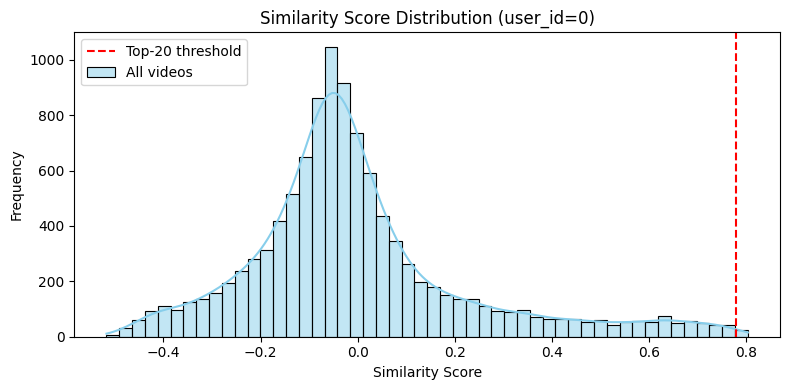

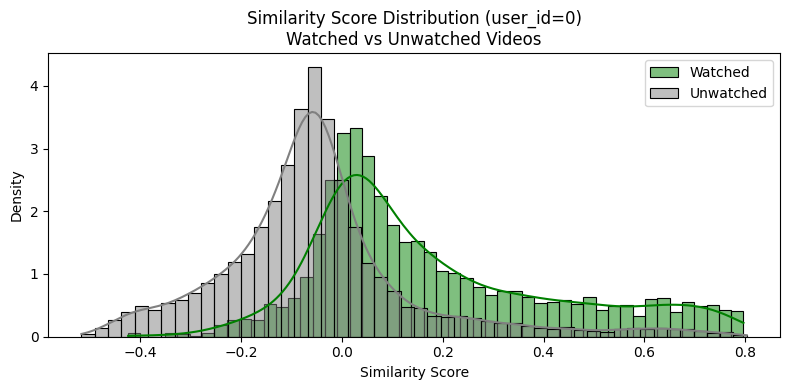

Recommendations for user 0: [(7293, 0.8032589961915251), (10378, 0.7968682002409396), (9862, 0.7854836527470618), (7100, 0.7826495049312623), (2372, 0.7823138865873301), (9299, 0.7786083897222269), (3969, 0.777779659642913), (4086, 0.7767415667656254), (5787, 0.7738095554226686), (3615, 0.7731759835799352)]


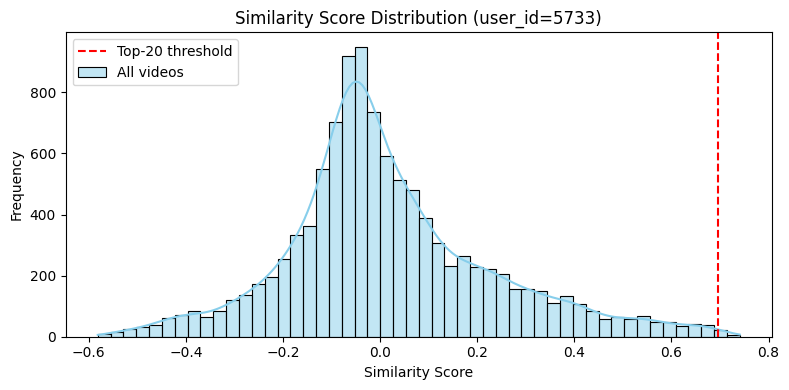

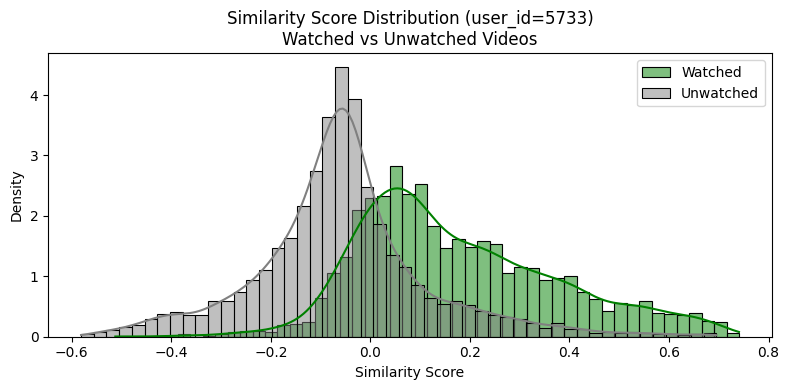

Recommendations for user 5733: [(8673, 0.6953303521054023), (8707, 0.6915082436879088), (3107, 0.68460335528018), (2576, 0.6818118098384233), (5754, 0.680034614059062), (9582, 0.6797680050314867), (6757, 0.6784207476929865), (4674, 0.678060158726479), (8172, 0.6777199437928937), (4659, 0.6745351181776509)]


In [8]:
def generate_recommendations(user_id, top_n=10, exclude_watched=True):
    """
    Generate recommendations for a user using cosine similarity between
    the user profile and video features.
    """
    if user_id not in user_id_map:
        print(f"User {user_id} not found in training data")
        return []
    
    user_idx = user_id_map[user_id]
    user_profile = user_profiles[user_idx].reshape(1, -1)
    
    # Calculate similarity between user profile and all videos
    similarities = cosine_similarity(user_profile, video_features_matrix)[0]
    
    video_ids = video_features['video_id'].values
    video_similarities = list(zip(video_ids, similarities))
    
    # Sort by similarity in descending order
    video_similarities.sort(key=lambda x: x[1], reverse=True)
    
    if exclude_watched:
        # Get list of videos the user has already watched
        watched_videos = set(interactions_train[
            interactions_train['user_id'] == user_id
        ]['video_id'].values)
        
        # Filter out watched videos
        video_similarities = [(vid, sim) for vid, sim in video_similarities if vid not in watched_videos]
    
    # Return top N recommended video IDs
    top_recommendations = [(vid, sim) for vid, sim in video_similarities[:top_n]]
    return top_recommendations

def plot_similarity_scores(user_id, top_n=10):
    """
    Plot similarity scores between a user's profile and all video feature vectors.
    """
    if user_id not in user_id_map:
        print(f"User {user_id} not found in training data")
        return
    
    user_idx = user_id_map[user_id]
    user_profile = user_profiles[user_idx].reshape(1, -1)
    
    # Compute similarities
    similarities = cosine_similarity(user_profile, video_features_matrix)[0]
    video_ids = video_features['video_id'].values

    # Get watched videos
    watched_videos = set(interactions_train[
        interactions_train['user_id'] == user_id
    ]['video_id'].values)

    # Build DataFrame
    similarity_df = pd.DataFrame({
        'video_id': video_ids,
        'similarity': similarities,
        'watched': [vid in watched_videos for vid in video_ids]
    })

    # Sort to highlight top N recommendations
    similarity_df_sorted = similarity_df.sort_values(by='similarity', ascending=False).reset_index(drop=True)
    top_recommended = similarity_df_sorted.head(top_n)

    # Plot
    plt.figure(figsize=(8, 4))
    sns.histplot(similarity_df['similarity'], bins=50, kde=True, label='All videos', color='skyblue')
    plt.axvline(top_recommended['similarity'].min(), color='red', linestyle='--', label=f'Top-{top_n} threshold')
    plt.title(f"Similarity Score Distribution (user_id={user_id})")
    plt.xlabel("Similarity Score")
    plt.ylabel("Frequency")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"img/similarity_distribution_user_{user_id}.png")
    plt.show()

def plot_similarity_seen_vs_unseen(user_id):
    """
    Compare similarity scores of videos seen vs unseen by the user.
    """
    if user_id not in user_id_map:
        print(f"User {user_id} not found.")
        return
    
    user_idx = user_id_map[user_id]
    user_profile = user_profiles[user_idx].reshape(1, -1)
    
    # Similarity between user profile and all videos
    similarities = cosine_similarity(user_profile, video_features_matrix)[0]
    video_ids = video_features['video_id'].values
    
    watched_videos = set(
        interactions_train[interactions_train['user_id'] == user_id]['video_id'].values
    )
    
    # Create a DataFrame with similarities and watched/unwatched status
    df = pd.DataFrame({
        'video_id': video_ids,
        'similarity': similarities,
        'watched': [vid in watched_videos for vid in video_ids]
    })

    # Plot
    plt.figure(figsize=(8, 4))
    sns.histplot(df[df['watched']]['similarity'], bins=50, kde=True, color='green', label='Watched', stat='density')
    sns.histplot(df[~df['watched']]['similarity'], bins=50, kde=True, color='gray', label='Unwatched', stat='density')
    
    plt.title(f"Similarity Score Distribution (user_id={user_id})\nWatched vs Unwatched Videos")
    plt.xlabel("Similarity Score")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"img/seen_unseen_distribution_user_{user_id}.png")
    plt.show()
    

for user_id in unique_users[:1]:
    recommendations = generate_recommendations(user_id, top_n=10)
    plot_similarity_scores(user_id, top_n=20)
    plot_similarity_seen_vs_unseen(user_id)
    print(f"Recommendations for user {user_id}: {recommendations}")

recommendations = generate_recommendations(5733, top_n=10)
plot_similarity_scores(5733, top_n=20)
plot_similarity_seen_vs_unseen(5733)
print(f"Recommendations for user {5733}: {recommendations}")

### Evaluation: Ranking Quality on Test Videos

The function `evaluate_model()` assesses how well the content-based recommender system ranks videos that the user has **actually seen** in the test set (`small_matrix`). It does this by computing standard ranking metrics at top-K.

---

#### Evaluation Setup:

- **Users evaluated**: All users present in the test set (`small_matrix`) and whose profiles were built from the training set (`big_matrix`).
- **Candidate set**: Only videos that each user has seen in the test set.
- **Ground truth**: Videos with a `watch_ratio_clamped` above a certain threshold (e.g., `0.7`) are considered **positive interactions** (i.e., liked).
- **Predictions**: Videos are ranked using **cosine similarity** between the user profile and the video feature vectors.

---

#### Metrics Computed:

For each user, the following metrics are computed at `k` (typically 5, 10, or 20):

| Metric        | Definition                                                                 |
|---------------|---------------------------------------------------------------------------|
| `Precision@k` | Fraction of top-k recommended videos that are truly liked                 |
| `Recall@k`    | Fraction of all liked videos that appear in the top-k                     |
| `NDCG@k`      | Discounted cumulative gain, rewarding relevant items near the top of the list |

---

#### Why This Evaluation Matters

- This method avoids unfairly evaluating on **unseen videos** by restricting ranking to the subset the user has actually seen.
- It gives a realistic view of how well the system **ranks known items**, which is particularly useful in **offline validation**.
- It highlights how the system prioritizes **truly preferred** content over neutral or low-engagement content.

---

#### Output

The function returns a dictionary:

```python
{
  'precision@k': float,
  'recall@k': float,
  'ndcg@k': float,
  'users_evaluated': int
}


In [9]:
def evaluate_model(k=10, positive_threshold=0.7):
    """
    Evaluate the ranking quality of already seen videos by the user (in small_matrix),
    using their profile learned from big_matrix.
    """
    print(f"Ranking evaluation on test videos... (top-{k})")

    # List of users to evaluate = those present in small_matrix + known users
    test_users = interactions_test['user_id'].unique()
    test_users = [u for u in test_users if u in user_id_map]

    precision_list = []
    recall_list = []
    ndcg_list = []
    skipped = 0

    for user_id in tqdm(test_users, desc="Evaluating users"):

        user_idx = user_id_map[user_id]
        user_profile = user_profiles[user_idx].reshape(1, -1)

        # Videos this user has seen in small_matrix
        user_test_data = interactions_test[
            (interactions_test['user_id'] == user_id) &
            (interactions_test['video_id'].isin(video_id_map))
        ]

        if user_test_data.empty:
            skipped += 1
            continue

        candidate_videos = user_test_data['video_id'].unique()

        # Ground truth: liked videos
        positive_videos = set(
            user_test_data[user_test_data['watch_ratio_clamped'] >= positive_threshold]['video_id']
        )

        if len(positive_videos) == 0:
            skipped += 1
            continue

        # Compute similarity between user profile and candidate videos
        candidate_indices = [video_id_map[vid] for vid in candidate_videos]
        candidate_features = video_features_matrix[candidate_indices]
        similarities = cosine_similarity(user_profile, candidate_features)[0]

        # Associate each video with its similarity
        ranked = sorted(zip(candidate_videos, similarities), key=lambda x: x[1], reverse=True)
        ranked_video_ids = [vid for vid, _ in ranked[:k]]

        # Evaluation
        recommended_set = set(ranked_video_ids)
        intersection = positive_videos & recommended_set

        precision = len(intersection) / k
        recall = len(intersection) / len(positive_videos)
        relevance = [1 if vid in positive_videos else 0 for vid in ranked_video_ids]
        ndcg = ndcg_score([relevance], [list(range(k, 0, -1))])

        precision_list.append(precision)
        recall_list.append(recall)
        ndcg_list.append(ndcg)

    print(f"Users evaluated: {len(precision_list)} / {len(test_users)}")
    print(f"Users skipped: {skipped}")

    return {
        'precision@k': np.mean(precision_list),
        'recall@k': np.mean(recall_list),
        'ndcg@k': np.mean(ndcg_list),
        'users_evaluated': len(precision_list)
    }


### Evaluation Results — Ranking on Test Set (Top-10)

The model was evaluated by ranking videos already seen by users in the test set (`small_matrix`). Only users whose profiles were available from the training set (`big_matrix`) were considered.

#### Summary:

- **Users evaluated**: 1411
- **Users skipped**: 0  
- **Evaluation threshold**: `watch_ratio_clamped ≥ 0.7` (positive interaction)
- **Top-K cutoff**: `k = 10`

| Metric        | Value   | Interpretation |
|---------------|---------|----------------|
| `Precision@10`| 0.8147  | Among the top 10 ranked videos per user, ~81% were truly liked (high quality of ranking) |
| `Recall@10`   | 0.0053  | Only 0.5% of all liked videos were recovered in the top-10 (due to high number of positives) |
| `NDCG@10`     | 0.9222  | Excellent ranking quality — relevant items appear very early in the list |

---

### Interpretation

- **High precision (0.81)**: The top-10 ranked videos for each user are highly aligned with their preferences. This indicates that user profiles and video feature vectors are **well-aligned** in the embedding space.

- **Very low recall (0.0053)**: Despite high precision, the proportion of all truly liked videos recovered is very small. This is expected given:
  - Users have **hundreds or thousands of positives** in the test set (average ~1850),
  - The top-K list contains only **10 predictions**.

- **High NDCG (0.92)**: The model is not only predicting liked videos, but is ranking them **very well** — relevant videos appear early in the list, which is crucial for recommendation.


In [10]:
for k in [5, 10, 20]:
    results = evaluate_model(k=k, positive_threshold=0.7)
    print(f"Precision@{k}: {results['precision@k']:.4f}")
    print(f"Recall@{k}:    {results['recall@k']:.4f}")
    print(f"NDCG@{k}:      {results['ndcg@k']:.4f}\n")


Ranking evaluation on test videos... (top-5)


Evaluating users: 100%|██████████| 1411/1411 [00:55<00:00, 25.59it/s]


Users evaluated: 1411 / 1411
Users skipped: 0
Precision@5: 0.8546
Recall@5:    0.0023
NDCG@5:      0.9382

Ranking evaluation on test videos... (top-10)


Evaluating users: 100%|██████████| 1411/1411 [00:56<00:00, 25.16it/s]


Users evaluated: 1411 / 1411
Users skipped: 0
Precision@10: 0.8549
Recall@10:    0.0047
NDCG@10:      0.9385

Ranking evaluation on test videos... (top-20)


Evaluating users: 100%|██████████| 1411/1411 [00:55<00:00, 25.47it/s]

Users evaluated: 1411 / 1411
Users skipped: 0
Precision@20: 0.8492
Recall@20:    0.0093
NDCG@20:      0.9408

